In [1]:
'''
Uncomment any one of the following for corresponding task's training/testing; 
This is needed to save the model with appropriate name
'''

task = 'task1'
# task = 'task2'
# task = 'task3'

In [1]:
import numpy as np
import sys
import gym
import pylab
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential,load_model
from keras.backend import clear_session
from keras.initializers import he_uniform
import random
from collections import deque
from matplotlib import pyplot as plt 
seed_value = 42

Using TensorFlow backend.
/opt/anaconda3/envs/mlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/mlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/mlproject/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/mlproject/lib/p

In [3]:
# Double Deep Q Learning Agent
class DDQN_Agent:
    def __init__(self, sspace_size, aspace_size):
        self.gamma = 1.0
        self.lr = 1e-3 
        self.epsilon = 1.0 
        self.decay = 0.999 
        self.min_epsilon = 0.01 
        self.bs = 32 
        self.xp = deque()
        self.xp_size = 0  
        self.xp_thres = 1000
        self.xp_max = 4000
        self.sspace_size = sspace_size
        self.aspace_size = aspace_size
        self.target = self.make_model()
        self.primary = self.make_model() 
        self.batch_size = 32
        self.counter = 0
        self.update_interval = 1
        self.visual = False 

    def make_model(self):
#         clear_session()
        model = Sequential()
        model.add(Dense(32, input_dim=self.sspace_size, activation='relu',
                        kernel_initializer=he_uniform(seed=seed_value)))
        model.add(Dense(32, activation='relu',
                        kernel_initializer=he_uniform(seed=seed_value)))
        model.add(Dense(self.aspace_size, activation='linear',
                        kernel_initializer=he_uniform(seed=seed_value)))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model 
        
    def update_step(self):
        if self.xp_size<self.xp_thres:
            return 
        xp_batch = random.sample(self.xp, self.batch_size)

        st_ = np.array([x[3] for x in xp_batch])
        st = np.array([x[0] for x in xp_batch])
        at = np.array([x[1] for x in xp_batch])
        rt = np.array([x[2] for x in xp_batch])
        done = np.array([x[4] for x in xp_batch])

        primary_Q_nxt = self.primary.predict(st_)
        at_ = np.argmax(primary_Q_nxt, axis = 1)  
        target_Q_nxt = self.target.predict(st_)
        primary_Q = self.primary.predict(st)
        for i in range(self.batch_size):
            if done[i]:
                primary_Q[i][at[i]] = rt[i]
            else:
                primary_Q[i][at[i]] = rt[i] + self.gamma*target_Q_nxt[i][at_[i]]
        self.primary.fit(st, primary_Q, batch_size = self.batch_size, epochs = 1, verbose = 0)
        
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.decay 

        self.counter += 1
        if self.update_interval == self.counter:
            self.target.set_weights(self.primary.get_weights())
            self.counter = 0
    
    def act(self, state):
        if random.random()<=self.epsilon: 
            return random.sample(range(0, self.aspace_size), 1)[0]
        else:
            state = np.reshape(state, (1, self.sspace_size))
            primary_out = self.primary.predict(state)
            a = np.argmax(primary_out[0])
            return a 

    def environment_step(self, st, at, rt, st_, done):
        if self.xp_size == self.xp_max:
            self.xp.popleft()
            self.xp_size -= 1
        self.xp.append([st, at, rt, st_, done])
        self.xp_size += 1
    

In [4]:
def train(model, model_save = False):
    env = gym.make('CartPole-v1')
    env.seed(seed_value) 
    np.random.seed(seed_value)

    MAX_EPISODE_LEN = 500

    
    if model == 'DDQN':
        agent = DDQN_Agent(env.observation_space.shape[0], env.action_space.n)
    
    score_list = []
    averages_ep = []
    episodes = []
    recent_scores = deque(maxlen=100)
    enough = 0

    for ep in range(4000):
        episodes.append(ep)
        done = 0 
        score = 0
        st = env.reset()

        while not done:
            if agent.visual:
                env.render()
            
            if model.endswith('DQN'): 
                at = agent.act(st)
                
            st_, rt, done, info = env.step(at)
            rt = rt if done == 0 or score == MAX_EPISODE_LEN-1 else -100
            
            if model.endswith('DQN'):
                agent.environment_step(st, at, rt, st_, done)
                agent.update_step()

            score += rt 
            st = st_ 

            if score == MAX_EPISODE_LEN:
                done = 1
            
            if done:
                score = score if score == MAX_EPISODE_LEN else score + 100
                score_list.append(score)
                recent_scores.append(score)
                mean_score = np.average(recent_scores)
                averages_ep.append(mean_score)
                print('episode:', ep, 'score:', score, 'mean of recent scores:', mean_score)
                if mean_score >= 475:
                    enough = 1 
        if enough: 
            break
            
    pylab.plot(episodes, averages_ep, 'r')
    pylab.plot(episodes, score_list, 'b')
    pylab.ylabel('Score', fontsize=18)
    pylab.xlabel('Steps', fontsize=18)

    if model_save:
        agent.primary.save('DDQN_Final_'+task+'.h5')

CartPoleEnv Task 3- Version 0.2.0, Noise case: 1
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                160       
_________________________________________

/opt/anaconda3/envs/mlproject3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/anaconda3/envs/mlproject3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym.envs.classic_control.cartpole.CartPoleEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


 24 score: 19.0 mean of recent scores: 16.16
episode: 25 score: 13.0 mean of recent scores: 16.03846153846154
episode: 26 score: 21.0 mean of recent scores: 16.22222222222222
episode: 27 score: 47.0 mean of recent scores: 17.321428571428573
episode: 28 score: 11.0 mean of recent scores: 17.103448275862068
episode: 29 score: 21.0 mean of recent scores: 17.233333333333334
episode: 30 score: 11.0 mean of recent scores: 17.032258064516128
episode: 31 score: 14.0 mean of recent scores: 16.9375
episode: 32 score: 10.0 mean of recent scores: 16.727272727272727
episode: 33 score: 12.0 mean of recent scores: 16.58823529411765
episode: 34 score: 13.0 mean of recent scores: 16.485714285714284
episode: 35 score: 14.0 mean of recent scores: 16.416666666666668
episode: 36 score: 14.0 mean of recent scores: 16.35135135135135
episode: 37 score: 16.0 mean of recent scores: 16.342105263157894
episode: 38 score: 12.0 mean of recent scores: 16.23076923076923
episode: 39 score: 23.0 mean of recent scores: 

episode: 157 score: 110.0 mean of recent scores: 108.96
episode: 158 score: 95.0 mean of recent scores: 109.73
episode: 159 score: 132.0 mean of recent scores: 110.97
episode: 160 score: 103.0 mean of recent scores: 111.87
episode: 161 score: 131.0 mean of recent scores: 113.08
episode: 162 score: 108.0 mean of recent scores: 114.0
episode: 163 score: 94.0 mean of recent scores: 114.66
episode: 164 score: 97.0 mean of recent scores: 115.47
episode: 165 score: 122.0 mean of recent scores: 116.5
episode: 166 score: 82.0 mean of recent scores: 117.2
episode: 167 score: 132.0 mean of recent scores: 118.37
episode: 168 score: 103.0 mean of recent scores: 119.19
episode: 169 score: 95.0 mean of recent scores: 120.03
episode: 170 score: 9.0 mean of recent scores: 119.98
episode: 171 score: 108.0 mean of recent scores: 120.61
episode: 172 score: 102.0 mean of recent scores: 121.49
episode: 173 score: 113.0 mean of recent scores: 122.5
episode: 174 score: 108.0 mean of recent scores: 123.41
epi

episode: 306 score: 262.0 mean of recent scores: 144.89
episode: 307 score: 322.0 mean of recent scores: 146.01
episode: 308 score: 308.0 mean of recent scores: 149.02
episode: 309 score: 451.0 mean of recent scores: 153.43
episode: 310 score: 483.0 mean of recent scores: 158.15
episode: 311 score: 500.0 mean of recent scores: 163.03
episode: 312 score: 432.0 mean of recent scores: 167.25
episode: 313 score: 260.0 mean of recent scores: 169.78
episode: 314 score: 486.0 mean of recent scores: 174.55
episode: 315 score: 500.0 mean of recent scores: 179.45
episode: 316 score: 500.0 mean of recent scores: 184.36
episode: 317 score: 444.0 mean of recent scores: 188.71
episode: 318 score: 500.0 mean of recent scores: 193.61
episode: 319 score: 500.0 mean of recent scores: 198.53
episode: 320 score: 500.0 mean of recent scores: 203.45
episode: 321 score: 500.0 mean of recent scores: 208.39
episode: 322 score: 500.0 mean of recent scores: 213.28
episode: 323 score: 500.0 mean of recent scores:

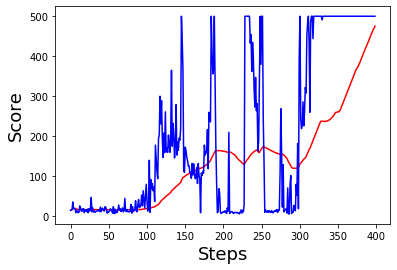

In [5]:
train('DDQN', True)